In [1]:
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-10-27 12:09:38.438241: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 12:09:38.443140: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-27 12:09:38.489647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-27 12:09:38.489689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-27 12:09:38.491323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
import random
from pathlib import Path
import time
import argparse
import json
import submitit
import shutil

In [4]:
from OptimizedDataGenerator import OptimizedDataGenerator
from loss import custom_loss
from models import CreateModel

/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [5]:
epochs = 200
batch_size = 256
val_batch_size = 256
train_file_size = 20
val_file_size = 5
n_filters = 5
pool_size = 3
learning_rate = 0.001
early_stopping_patience = 50

### Generating Training and Validation Datasets


Need to run:
- stamp
- training generator 
- validation generator 


In [6]:
# paths
data_directory_path = "./datasets/recon3D/" # "/net/scratch/badea/dataset8/unflipped/"
labels_directory_path = "./datasets/labels/" # "/net/scratch/badea/dataset8/unflipped/"

# create tf records directory
# stamp = '%08x' % random.randrange(16**8)
stamp = "3e778b82"
output_directory = Path(f"./tfrecords_{stamp}").resolve()
os.makedirs(output_directory, exist_ok=True)
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()
tfrecords_dir_test = Path(output_directory, f"tfrecords_test_{stamp}").resolve()

In [7]:
stamp = "3e778b82"

In [8]:
# Trainning Generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    file_count = train_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    save=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_train,
)
print(f"Training data generator created in {time.time() - start_time} seconds.")

Directory /home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_3e778b82/tfrecords_train_3e778b82 does not exist and cannot be removed.
Found 20 files to process
First file: ./datasets/recon3D/recon3D_data_d17301.parquet


Saving batches as TFRecords: 100%|██████████| 3905/3905 [02:26<00:00, 26.61it/s]


Training data generator created in 170.48387932777405 seconds.


In [9]:
training_generator = OptimizedDataGenerator(
load_from_tfrecords_dir = f"/home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_{stamp}/tfrecords_train_{stamp}/",
shuffle = True,
seed = 13,
quantize = True
)

In [10]:
start_time = time.time()
validation_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    file_count = val_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    files_from_end=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_validation,
)
print(f"Validation data generator created in {time.time() - start_time} seconds.")

Directory /home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_3e778b82/tfrecords_validation_3e778b82 does not exist and cannot be removed.
Found 5 files to process
First file: ./datasets/recon3D/recon3D_data_d17439.parquet


Saving batches as TFRecords: 100%|██████████| 976/976 [00:20<00:00, 48.52it/s] 


Validation data generator created in 26.13850212097168 seconds.


In [10]:
validation_generator = OptimizedDataGenerator(
load_from_tfrecords_dir = f"/home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_{stamp}/tfrecords_validation_{stamp}/",
shuffle = True,
seed = 13,
quantize = True
)

<h2> Creating Model and Running <h2>

In [8]:
model = CreateModel((13,21,2), n_filters=5, pool_size=3)
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [11]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, Callback

checkpoint_directory = Path(f"./checkpoints_{stamp}").resolve()
checkpoint_directory.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

checkpoint_filepath = Path(checkpoint_directory, 'weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5').resolve()

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
)

csvlogger_directory = Path("./csvlogs").resolve()
csvlogger_directory.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

csv_logger = CSVLogger(Path(csvlogger_directory, f'training_log_{stamp}.csv').resolve(), append=True)

print(f"✓ Checkpoint directory: {checkpoint_directory}")
print(f"✓ Checkpoint files will be saved as: weights.XX-tX.XX-vX.XX.hdf5")

✓ Checkpoint directory: /home/hep/ac5222/Project/smart-pixels-ml-2/checkpoints_3e778b82
✓ Checkpoint files will be saved as: weights.XX-tX.XX-vX.XX.hdf5


In [14]:
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    callbacks=[es, mcp, csv_logger],
                    epochs=epochs,
                    shuffle=False, # shuffling now occurs within the data-loader
                    verbose=1)

Epoch 1/200
3905/3905 [==============================] - 318s 81ms/step - loss: -224.3857 - val_loss: -540.5778
Epoch 2/200
  55/3905 [..............................] - ETA: 3:43 - loss: -428.5323

KeyboardInterrupt: 

### Run from Checkpoint

In [15]:
# Find the latest checkpoint file
import glob

checkpoint_directory = Path(f"./checkpoints_{stamp}").resolve()
checkpoint_files = sorted(glob.glob(str(checkpoint_directory / "weights.*.hdf5")))

'''
ONlY IF YOU WANT TO REFERENCE A SPECIFIC CHECKPOINT
#checkpoint_files_directory = "/home/hep/ac5222/Project/smart-pixels-ml-2/checkpoints_3e778b82/weights.01-t-123.78-v-609.95.hdf5"
#checkpoint_files = sorted(glob.glob(str(checkpoint_files_directory)))
'''

if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"Loading weights from: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
    
    # Extract epoch number from filename to resume training
    import re
    match = re.search(r'weights\.(\d+)-', latest_checkpoint)
    if match:
        initial_epoch = int(match.group(1)) + 1
        print(f"Resuming from epoch {initial_epoch}")
    else:
        initial_epoch = 0
else:
    print("No checkpoint files found, starting from scratch")
    initial_epoch = 0

# Now train with initial_epoch parameter
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    callbacks=[es, mcp, csv_logger],
                    epochs=epochs,
                    initial_epoch=initial_epoch,  # Add this parameter
                    shuffle=False,
                    verbose=1)

Loading weights from: /home/hep/ac5222/Project/smart-pixels-ml-2/checkpoints_3e778b82/weights.117-t-1220.46-v-1137.35.hdf5
Resuming from epoch 118
Epoch 119/200
  80/3905 [..............................] - ETA: 3:42 - loss: -1155.8506

KeyboardInterrupt: 

### Test Data Generator

In [12]:
# data generator (TEST)
start_time = time.time()

test_generator = OptimizedDataGenerator(
        data_directory_path = data_directory_path,
        labels_directory_path = labels_directory_path,
        is_directory_recursive = False,
        file_type = "parquet",
        data_format = "3D",
        batch_size = val_batch_size,
        file_count = val_file_size,
        to_standardize= True,
        include_y_local= False,
        labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
        input_shape = (2,13,21), # (20,13,21),
        transpose = (0,2,3,1),
        files_from_end=True,
        use_time_stamps = [0,19],
        tfrecords_dir = tfrecords_dir_test,
    )

print(f"Test data generator created in {time.time() - start_time} seconds.")

Directory /home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_3e778b82/tfrecords_test_3e778b82 does not exist and cannot be removed.
Found 5 files to process
First file: ./datasets/recon3D/recon3D_data_d17439.parquet


Saving batches as TFRecords: 100%|██████████| 976/976 [00:33<00:00, 28.95it/s]


Error saving batch 975: /home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_3e778b82/tfrecords_test_3e778b82/batch_975.tfrecord; Disk quota exceeded
Test data generator created in 40.03697848320007 seconds.


In [13]:
import tensorflow as tf
import random
from pathlib import Path
import pandas as pd
import argparse
import submitit
import json 
import numpy as np
import shutil

minval=1e-9

def evaluate(config):

    # update %j with actual job number
    try:
        job_env = submitit.JobEnvironment()
        config["outFileName"] = Path(str(config["outFileName"]).replace("%j", str(job_env.job_id)))
    except:
        config["outFileName"] = Path(str(config["outFileName"]).replace("%j", "%08x" % random.randrange(16**8)))
    output_directory = config["outFileName"].parent
    os.makedirs(output_directory, exist_ok=True)
    print(output_directory)

    #create tf records directory
    #tfrecords_dir = Path(output_directory, f"tfrecords_{'%08x' % random.randrange(16**8)}").resolve()

    test_generator = OptimizedDataGenerator(
        load_from_tfrecords_dir= f"/home/hep/ac5222/Project/smart-pixels-ml-2/tfrecords_{stamp}/tfrecords_test_{stamp}/",
        shuffle = True,
        seed = 13,
        quantize = True
    )

    # build model, load weights, predict
    model=CreateModel((13,21,2), n_filters=config["n_filters"], pool_size=config["pool_size"])
    model.load_weights(config["weightsPath"])
    p_test = model.predict(test_generator)

    complete_truth = None
    for _, y in test_generator:
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

    # creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
    df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

    # stores all true values in same matrix as xtrue, ytrue, etc.
    df['xtrue'] = complete_truth[:,0]
    df['ytrue'] = complete_truth[:,1]
    df['cotAtrue'] = complete_truth[:,2]
    df['cotBtrue'] = complete_truth[:,3]
    df['M11'] = minval+tf.math.maximum(df['M11'], 0)
    df['M22'] = minval+tf.math.maximum(df['M22'], 0)
    df['M33'] = minval+tf.math.maximum(df['M33'], 0)
    df['M44'] = minval+tf.math.maximum(df['M44'], 0)

    # calculates residuals for x, y, cotA, cotB
    residuals = df['xtrue'] - df['x']
    residualsy = df['ytrue'] - df['y']
    residualsA = df['cotAtrue'] - df['cotA']
    residualsB = df['cotBtrue'] - df['cotB']

    # stores results as csv
    df.to_csv(config["outFileName"], header=True, index=False)

    # clean up tf records
    # shutil.rmtree(tfrecords_dir)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [14]:
config = {
    "weightsPath": "/home/hep/ac5222/Project/smart-pixels-ml-2/checkpoints_3e778b82/weights.01-t-123.78-v-609.95.hdf5",
    "outFileName": "/home/hep/ac5222/Project/smart-pixels-ml-2/evaluation_results.csv",
    "data_directory_path": "/home/hep/ac5222/Project/smart-pixels-ml-2/datasets/recon3D",
    "labels_directory_path": "/home/hep/ac5222/Project/smart-pixels-ml-2/datasets/labels",
    "n_filters": 5,
    "pool_size": 3,
    "val_batch_size": 256,
    "val_file_size": 5
}
evaluate(config)

/home/hep/ac5222/Project/smart-pixels-ml-2


748/976 [=====================>........] - ETA: 14s

2025-10-27 12:16:20.967855: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 12 [Op:IteratorGetNext] name: 
Traceback (most recent call last):

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/keras/src/engine/data_adapter.py", 

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 12 [Op:IteratorGetNext] name: 
Traceback (most recent call last):

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/OptimizedDataGenerator.py", line 402, in __getitem__
    for X_batch, y_batch in parsed_dataset:

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 810, in __next__
    return self._next_internal()

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 773, in _next_internal
    ret = gen_dataset_ops.iterator_get_next(

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 3029, in iterator_get_next
    _ops.raise_from_not_ok_status(e, name)

  File "/home/hep/ac5222/Project/smart-pixels-ml-2/venv/lib64/python3.9/site-packages/tensorflow/python/framework/ops.py", line 5883, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} corrupted record at 12 [Op:IteratorGetNext] name: 


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_predict_function_10162]

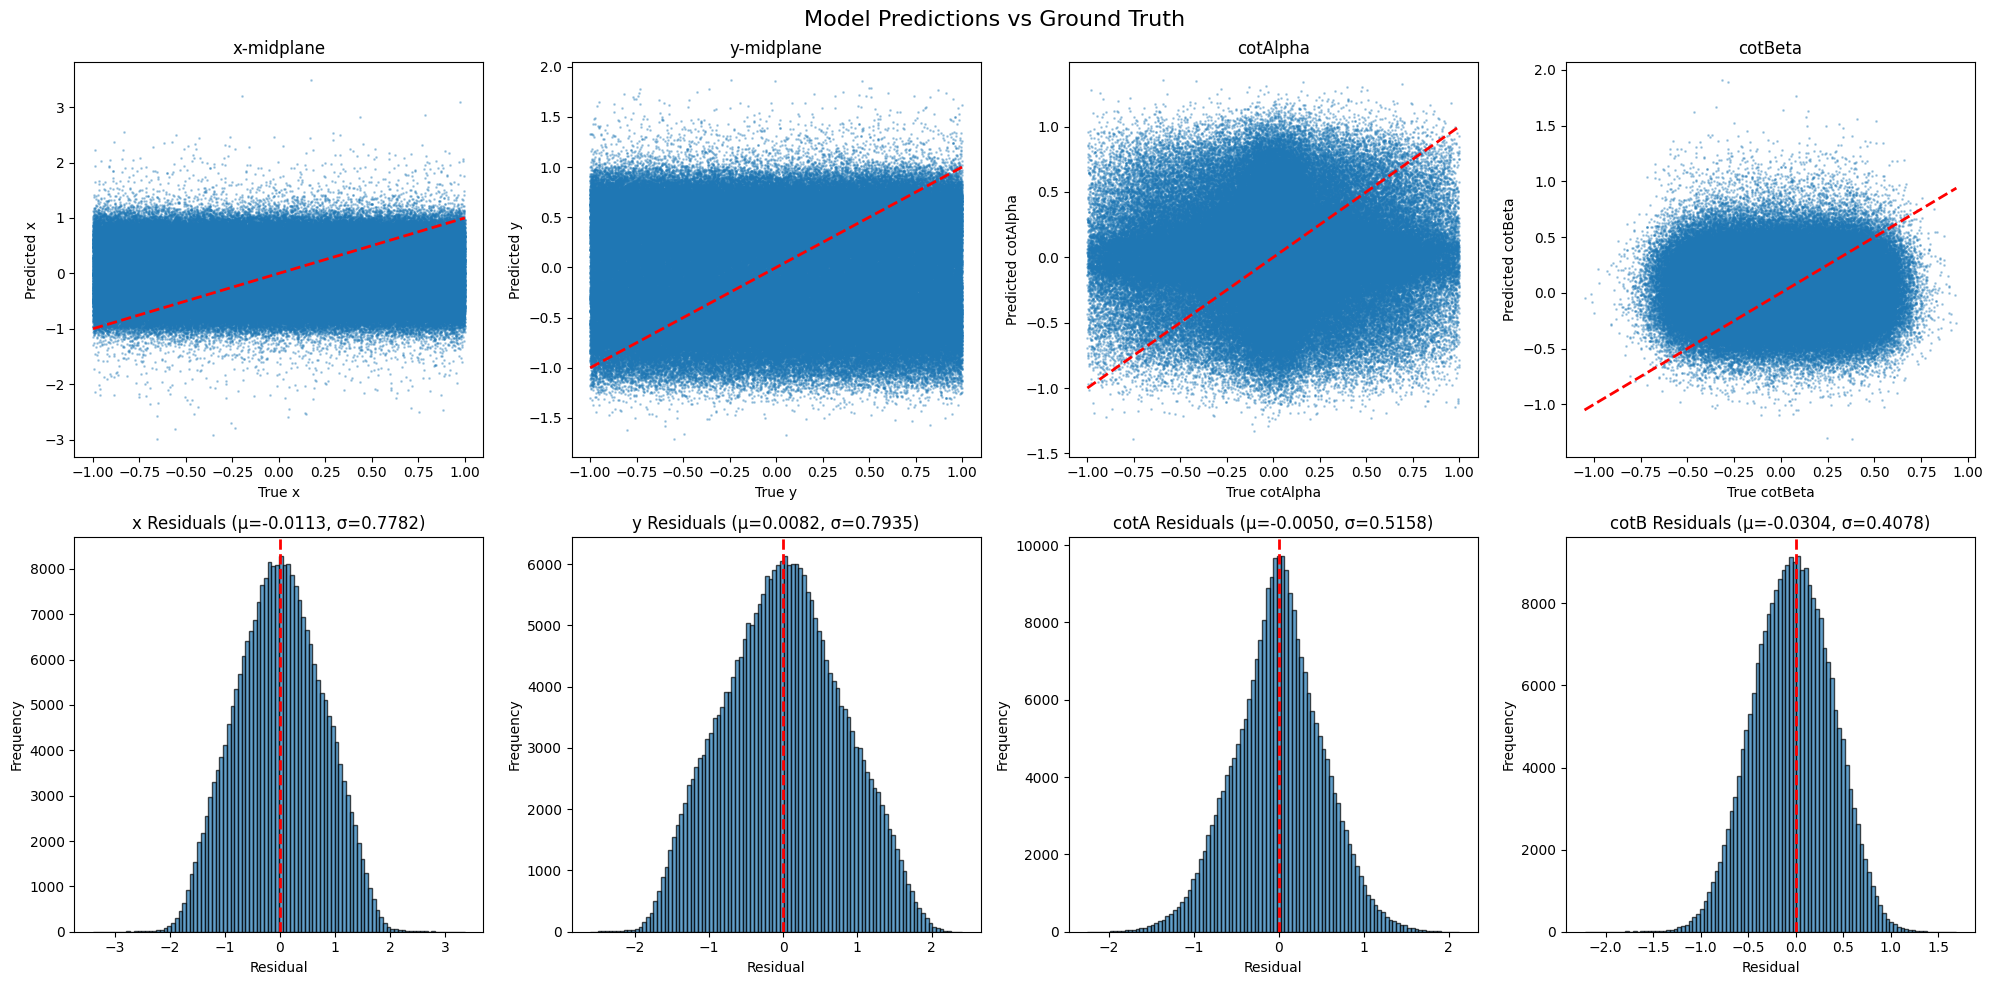


=== Summary Statistics ===

x-midplane:
  Mean residual: -0.011306
  Std residual:  0.778152
  RMSE:          0.778233

y-midplane:
  Mean residual: 0.008238
  Std residual:  0.793495
  RMSE:          0.793536

cotAlpha:
  Mean residual: -0.004950
  Std residual:  0.515826
  RMSE:          0.515849

cotBeta:
  Mean residual: -0.030431
  Std residual:  0.407786
  RMSE:          0.408919


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read the results
test_result = pd.read_csv("/home/hep/ac5222/Project/smart-pixels-ml-2/evaluation_results.csv")

# Calculate residuals
test_result['residual_x'] = test_result['xtrue'] - test_result['x']
test_result['residual_y'] = test_result['ytrue'] - test_result['y']
test_result['residual_cotA'] = test_result['cotAtrue'] - test_result['cotA']
test_result['residual_cotB'] = test_result['cotBtrue'] - test_result['cotB']

# Set up the figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Model Predictions vs Ground Truth', fontsize=16)

# Plot 1: x prediction vs true
axes[0, 0].scatter(test_result['xtrue'], test_result['x'], alpha=0.3, s=1)
axes[0, 0].plot([test_result['xtrue'].min(), test_result['xtrue'].max()], 
                [test_result['xtrue'].min(), test_result['xtrue'].max()], 'r--', lw=2)
axes[0, 0].set_xlabel('True x')
axes[0, 0].set_ylabel('Predicted x')
axes[0, 0].set_title('x-midplane')

# Plot 2: y prediction vs true
axes[0, 1].scatter(test_result['ytrue'], test_result['y'], alpha=0.3, s=1)
axes[0, 1].plot([test_result['ytrue'].min(), test_result['ytrue'].max()], 
                [test_result['ytrue'].min(), test_result['ytrue'].max()], 'r--', lw=2)
axes[0, 1].set_xlabel('True y')
axes[0, 1].set_ylabel('Predicted y')
axes[0, 1].set_title('y-midplane')

# Plot 3: cotA prediction vs true
axes[0, 2].scatter(test_result['cotAtrue'], test_result['cotA'], alpha=0.3, s=1)
axes[0, 2].plot([test_result['cotAtrue'].min(), test_result['cotAtrue'].max()], 
                [test_result['cotAtrue'].min(), test_result['cotAtrue'].max()], 'r--', lw=2)
axes[0, 2].set_xlabel('True cotAlpha')
axes[0, 2].set_ylabel('Predicted cotAlpha')
axes[0, 2].set_title('cotAlpha')

# Plot 4: cotB prediction vs true
axes[0, 3].scatter(test_result['cotBtrue'], test_result['cotB'], alpha=0.3, s=1)
axes[0, 3].plot([test_result['cotBtrue'].min(), test_result['cotBtrue'].max()], 
                [test_result['cotBtrue'].min(), test_result['cotBtrue'].max()], 'r--', lw=2)
axes[0, 3].set_xlabel('True cotBeta')
axes[0, 3].set_ylabel('Predicted cotBeta')
axes[0, 3].set_title('cotBeta')

# Plot 5-8: Residual distributions
axes[1, 0].hist(test_result['residual_x'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'x Residuals (μ={test_result["residual_x"].mean():.4f}, σ={test_result["residual_x"].std():.4f})')
axes[1, 0].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 1].hist(test_result['residual_y'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'y Residuals (μ={test_result["residual_y"].mean():.4f}, σ={test_result["residual_y"].std():.4f})')
axes[1, 1].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 2].hist(test_result['residual_cotA'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Residual')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title(f'cotA Residuals (μ={test_result["residual_cotA"].mean():.4f}, σ={test_result["residual_cotA"].std():.4f})')
axes[1, 2].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 3].hist(test_result['residual_cotB'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 3].set_xlabel('Residual')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].set_title(f'cotB Residuals (μ={test_result["residual_cotB"].mean():.4f}, σ={test_result["residual_cotB"].std():.4f})')
axes[1, 3].axvline(0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.savefig('test_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"\nx-midplane:")
print(f"  Mean residual: {test_result['residual_x'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_x'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_x']**2).mean()):.6f}")

print(f"\ny-midplane:")
print(f"  Mean residual: {test_result['residual_y'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_y'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_y']**2).mean()):.6f}")

print(f"\ncotAlpha:")
print(f"  Mean residual: {test_result['residual_cotA'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_cotA'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_cotA']**2).mean()):.6f}")

print(f"\ncotBeta:")
print(f"  Mean residual: {test_result['residual_cotB'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_cotB'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_cotB']**2).mean()):.6f}")